In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import small_CUB, CUB, SubColumn
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

# Get rid of gray scale images

filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/025.Pelagic_Cormorant/Pelagic_Cormorant_0022_23802.jpg
image id: 1401
class id: 25
bird name: 025.Pelagic_Cormorant
is_test: 0
image size: (375, 500)


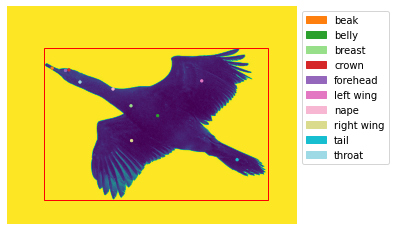

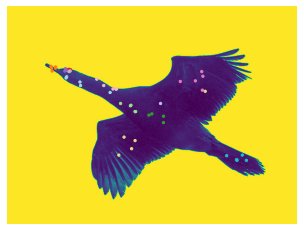

In [28]:
# bad gray-scale image
filename = '/data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/025.Pelagic_Cormorant/Pelagic_Cormorant_0022_23802.jpg'
describe_bird(filename)

In [41]:
# filter out bad images
image_dir = '../datasets/bird_data/CUB_200_2011/images/'
images_path = [os.path.join(os.path.dirname(image_dir), image_path, i) \
                            for image_path in os.listdir(image_dir) \
                            for i in os.listdir(os.path.join(os.path.dirname(image_dir),
                                                             image_path)) if i[-3:]=="jpg"]
gray_scale_images = []
t = tqdm.tqdm(images_path, desc=f'len(gray_scale_images)={len(gray_scale_images)}')
for fn in t:
    t.set_description(f'len(gray_scale_images)={len(gray_scale_images)}')
    if len(np.array(Image.open(fn)).shape) != 3:
        gray_scale_images.append(fn)

len(gray_scale_images)=8: 100%|██████████| 11788/11788 [01:18<00:00, 150.68it/s]


In [43]:
for fn in gray_scale_images:
    print(os.path.basename(fn))
#     describe_bird(fn)    

Clark_Nutcracker_0020_85099.jpg
Pelagic_Cormorant_0022_23802.jpg
Mallard_0130_76836.jpg
White_Necked_Raven_0070_102645.jpg
Western_Gull_0002_54825.jpg
Brewer_Blackbird_0028_2682.jpg
Ivory_Gull_0040_49180.jpg
Ivory_Gull_0085_49456.jpg


# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


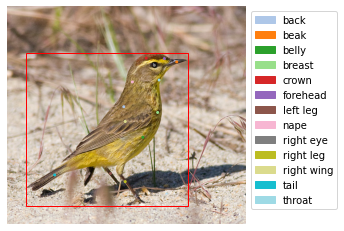

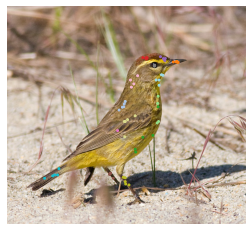

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


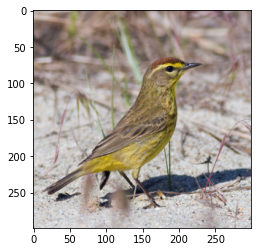

In [45]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = Subset(cub, train_indices)
cub_test = Subset(cub, test_indices)

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.show()
    
show_cub_data(cub_test, 30)